# NYC Jobs Data Analysis & Processing
# Author: Arjun
# Description:
# This notebook performs data exploration, data cleaning, feature engineering,
# visualizations, and testing on the NYC Jobs dataset as part of the assessment.

In [251]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("pyspark-assesment") \
    .getOrCreate()

### Read data

In [252]:
raw_df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)
raw_df.printSchema()
raw_df.count()

root
 |-- Job ID: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: string (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: string (nullable = true)
 |-- Salary Range To: string (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable = true)
 |-- Work Locatio

2946

## COUNT

In [120]:
df.count()

2946

In [253]:
from pyspark.sql import functions as F

# Null counts
raw_nulls = raw_df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in raw_df.columns
])
raw_nulls.show(truncate=False)

# Distinct job categories
raw_df.select("Job Category").distinct().count()

# Top 10 job categories (raw)
raw_df.groupBy("Job Category") \
      .count() \
      .orderBy(F.desc("count")) \
      .limit(10) \
      .show()

+------+------+------------+--------------+--------------+-------------------+-------------+-----+------------+-----------------------------+-----------------+---------------+----------------+-------------+------------------+---------------+-------------------------+----------------+----------------------+--------+-----------+---------------+-------------------+---------------------+------------+----------+---------------+------------+
|Job ID|Agency|Posting Type|# Of Positions|Business Title|Civil Service Title|Title Code No|Level|Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|Salary Frequency|Work Location|Division/Work Unit|Job Description|Minimum Qual Requirements|Preferred Skills|Additional Information|To Apply|Hours/Shift|Work Location 1|Recruitment Contact|Residency Requirement|Posting Date|Post Until|Posting Updated|Process Date|
+------+------+------------+--------------+--------------+-------------------+-------------+-----+------------+---------

# DATA PROCESSING FUNCTIONS
### This section defines reusable PySpark functions to clean and transform the data.
### Steps include:
### Cleaning column names
### Casting salary columns
### Cleaning text fields
### Mapping degree levels
### Extracting posting year
### Dropping unused columns
### These functions are combined into a single processing pipeline.


In [254]:
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import re

In [256]:
def cast_salary_columns(df: DataFrame) -> DataFrame:
    return (
        df.withColumn("salary_from", F.col("salary_range_from").cast("int"))
          .withColumn("salary_to", F.col("salary_range_to").cast("int"))
          .withColumn("avg_salary", (F.col("salary_from") + F.col("salary_to")) / 2)
    )

In [255]:
def clean_column_names(df: DataFrame) -> DataFrame:
    for col in df.columns:
        new_col = col.lower()
        new_col = re.sub(r"[^a-zA-Z0-9]+", "_", new_col)
        new_col = re.sub(r"_+", "_", new_col)
        new_col = new_col.strip("_")
        df = df.withColumnRenamed(col, new_col)
    return df

In [257]:
def clean_text_columns(df: DataFrame, cols: list) -> DataFrame:
    for c in cols:
        df = df.withColumn(
            c,
            F.trim(F.regexp_replace(F.col(c), r"[\n\r]", " "))
        )
    return df

In [258]:
def map_degree_level(df: DataFrame) -> DataFrame:
    req = F.lower(F.col("minimum_qual_requirements"))
    return df.withColumn(
        "degree_level",
        F.when(req.contains("phd"), 4)
         .when(req.contains("doctor"), 4)
         .when(req.contains("master"), 3)
         .when(req.contains("bachelor"), 2)
         .when(req.contains("associate"), 1.5)
         .when(req.contains("high school"), 1)
         .otherwise(None)
    )

In [259]:
def extract_posting_year(df: DataFrame) -> DataFrame:
    df = df.withColumn(
        "posting_date",
        F.to_timestamp("posting_date", "yyyy-MM-dd'T'HH:mm:ss.SSS")
    )
    return df.withColumn("posting_year", F.year("posting_date"))

In [260]:
def process_data(df: DataFrame) -> DataFrame:
    df = clean_column_names(df)
    df = cast_salary_columns(df)
    df = clean_text_columns(df, ["job_description", "preferred_skills"])

    df = df.replace("", None).replace("null", None)

    df = map_degree_level(df)
    df = extract_posting_year(df)

    df = df.withColumn("degree_level", F.col("degree_level").cast("double"))
    df = df.withColumn("posting_year", F.col("posting_year").cast("int"))

    df = df.fillna({
        "degree_level": 0,
        "posting_year": 9999
    })

    return df

In [261]:
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)
processed_df = process_data(df)
processed_df.printSchema()
processed_df.select("job_id", "agency", "business_title", "salary_from", "salary_to", "avg_salary", "degree_level", "posting_year").show(10, truncate=False)

root
 |-- job_id: string (nullable = true)
 |-- agency: string (nullable = true)
 |-- posting_type: string (nullable = true)
 |-- of_positions: string (nullable = true)
 |-- business_title: string (nullable = true)
 |-- civil_service_title: string (nullable = true)
 |-- title_code_no: string (nullable = true)
 |-- level: string (nullable = true)
 |-- job_category: string (nullable = true)
 |-- full_time_part_time_indicator: string (nullable = true)
 |-- salary_range_from: string (nullable = true)
 |-- salary_range_to: string (nullable = true)
 |-- salary_frequency: string (nullable = true)
 |-- work_location: string (nullable = true)
 |-- division_work_unit: string (nullable = true)
 |-- job_description: string (nullable = true)
 |-- minimum_qual_requirements: string (nullable = true)
 |-- preferred_skills: string (nullable = true)
 |-- additional_information: string (nullable = true)
 |-- to_apply: string (nullable = true)
 |-- hours_shift: string (nullable = true)
 |-- work_location_

In [262]:
processed_df.select( "job_id", "agency", "business_title", "salary_from", "salary_to", "avg_salary", "degree_level", "posting_year" ).show(20, truncate=False)

+------+------------------------------+----------------------------------------------------+-----------+---------+----------+------------+------------+
|job_id|agency                        |business_title                                      |salary_from|salary_to|avg_salary|degree_level|posting_year|
+------+------------------------------+----------------------------------------------------+-----------+---------+----------+------------+------------+
|87990 |DEPARTMENT OF BUSINESS SERV.  |Account Manager                                     |42405      |65485    |53945.0   |1.0         |9999        |
|97899 |DEPARTMENT OF BUSINESS SERV.  |EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT            |60740      |162014   |111377.0  |1.0         |2012        |
|132292|NYC HOUSING AUTHORITY         |Maintenance Worker - Technical Services-Heating Unit|51907      |54580    |53243.5   |0.0         |9999        |
|132292|NYC HOUSING AUTHORITY         |Maintenance Worker - Technical Services-Heating U

# DATA EXPLORATION
### In this section, I explore the raw NYC Jobs dataset.
### I compute KPIs such as:
### - Total job postings
### - Top job categories
### - Salary statistics
### - Degree requirements
### - Posting trends

#### KPI 1: Number of job postings per category (Top 10)

In [263]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [264]:
kpi1 = (
    processed_df.groupBy("job_category")
                .count()
                .orderBy(F.desc("count"))
                .limit(10)
)
print("KPI 1: Top 10 Job Categories")
kpi1.show(truncate=False)

=== KPI 1: Top 10 Job Categories ===
+-----------------------------------------+-----+
|job_category                             |count|
+-----------------------------------------+-----+
|Engineering, Architecture, & Planning    |504  |
|Technology, Data & Innovation            |313  |
|Legal Affairs                            |226  |
|Public Safety, Inspections, & Enforcement|182  |
|Building Operations & Maintenance        |181  |
|Finance, Accounting, & Procurement       |169  |
|Administration & Human Resources         |134  |
|Constituent Services & Community Programs|129  |
|Health                                   |125  |
|Policy, Research & Analysis              |124  |
+-----------------------------------------+-----+



#### KP2:Whats the salary distribution per job category?

In [265]:
kpi2 = (
    processed_df.groupBy("job_category")
                .agg(
                    F.avg("avg_salary").alias("mean_salary"),
                    F.expr("percentile_approx(avg_salary, 0.5)").alias("median_salary"),
                    F.min("avg_salary").alias("min_salary"),
                    F.max("avg_salary").alias("max_salary")
                )
                .orderBy(F.desc("mean_salary"))
)
print("KPI 2: Salary Distribution per Job Category")
kpi2.show(truncate=False)

=== KPI 2: Salary Distribution per Job Category ===
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+-------------+----------+----------+
|job_category                                                                                                                                                                                             |mean_salary       |median_salary|min_salary|max_salary|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+-------------+----------+----------+
|Administration & Human Resources Finance, Accounting, & Procurement Building Operations & Maintenance                                                                     

#### KP3: Is there any correlation between the higher degree and the salary?

In [266]:
corr = processed_df.stat.corr("degree_level", "avg_salary")
print("KPI 3: Correlation Between Degree Level and Salary")
print("Correlation:", corr)

=== KPI 3: Correlation Between Degree Level and Salary ===
Correlation: 0.16432168660628949


#### KPI 4 Whats the job posting having the highest salary per agency

In [267]:
w = Window.partitionBy("agency").orderBy(F.desc("avg_salary"))

kpi4 = (
    processed_df.withColumn("rn", F.row_number().over(w))
                .filter(F.col("rn") == 1)
                .drop("rn")
                .select("agency", "business_title", "avg_salary", "salary_from", "salary_to")
)
print("KPI 4: Highest Salary Posting per Agency")
kpi4.show(truncate=False)

=== KPI 4: Highest Salary Posting per Agency ===
+------------------------------+------------------------------------------------------------+----------+-----------+---------+
|agency                        |business_title                                              |avg_salary|salary_from|salary_to|
+------------------------------+------------------------------------------------------------+----------+-----------+---------+
|LANDMARKS PRESERVATION COMM   |LANDMARKS PRESERVATIONIST, PRESERVATION DEPT                |60103.5   |55910      |64297    |
|OFFICE OF COLLECTIVE BARGAININ|COLLEGE AIDE - CLERICAL                                     |9.0       |8          |10       |
|FIRE DEPARTMENT               |Senior Enterprise Applications Integration Developer        |120474.5  |96020      |144929   |
|ADMIN FOR CHILDREN'S SVCS     |Assistant Commissioner                                      |117474.5  |78574      |156375   |
|MANHATTAN COMMUNITY BOARD #8  |Community Assistant           

#### KPI 5 :Whats the job positings average salary per agency for the last 2 years?

In [268]:
max_year = processed_df.agg(F.max("posting_year")).first()[0]
df_last2 = processed_df.filter(F.col("posting_year") >= max_year - 1)

kpi5 = (
    df_last2.groupBy("agency")
            .agg(F.avg("avg_salary").alias("avg_salary_last_2_years"))
            .orderBy(F.desc("avg_salary_last_2_years"))
)
print("KPI 5: Average Salary per Agency (Last 2 Years)")
kpi5.show(truncate=False)

=== KPI 5: Average Salary per Agency (Last 2 Years) ===
+------------------------------+-----------------------+
|agency                        |avg_salary_last_2_years|
+------------------------------+-----------------------+
|NYC EMPLOYEES RETIREMENT SYS  |105795.97619047618     |
|DEPARTMENT OF INVESTIGATION   |103271.64285714286     |
|FINANCIAL INFO SVCS AGENCY    |99705.90909090909      |
|DEPT OF DESIGN & CONSTRUCTION |96089.06410256411      |
|NYC HOUSING AUTHORITY         |88337.99689440994      |
|DEPT OF INFO TECH & TELECOMM  |85685.03773584905      |
|NYC DEPT OF VETERANS' SERVICES|82653.0                |
|DEPT OF PARKS & RECREATION    |82497.95               |
|DEPT OF CITYWIDE ADMIN SVCS   |82237.875              |
|DEPT OF ENVIRONMENT PROTECTION|80152.17543859649      |
|DEPARTMENT OF FINANCE         |79593.83333333333      |
|DEPARTMENT OF TRANSPORTATION  |79339.5487804878       |
|DEPARTMENT OF SANITATION      |79293.35               |
|LAW DEPARTMENT                |

#### KPI6: What are the highest paid skills in the US market?

In [269]:
skills = [
    "python", "sql", "excel", "tableau", "power bi", "data analysis",
    "project management", "leadership", "communication", "customer service",
    "microsoft office", "strategic planning", "problem solving", "machine learning",
    "cloud", "aws", "azure", "research"
]

df_skills = processed_df.withColumn("skill_text", F.lower(F.col("preferred_skills")))

for s in skills:
    df_skills = df_skills.withColumn(
        s.replace(" ", "_"),
        F.when(F.col("skill_text").like(f"%{s}%"), s).otherwise(None)
    )

skill_cols = [s.replace(" ", "_") for s in skills]

df_exploded = df_skills.select(
    "avg_salary",
    F.explode(F.array(*skill_cols)).alias("skill")
).filter(F.col("skill").isNotNull())

kpi6 = (
    df_exploded.groupBy("skill")
               .agg(F.avg("avg_salary").alias("avg_salary_for_skill"))
               .orderBy(F.desc("avg_salary_for_skill"))
)
print("KPI 6: Highest Paid Skills")
kpi6.show(truncate=False)

=== KPI 6: Highest Paid Skills ===
+------------------+--------------------+
|skill             |avg_salary_for_skill|
+------------------+--------------------+
|strategic planning|115489.28571428571  |
|azure             |106251.11111111111  |
|cloud             |99955.5303030303    |
|leadership        |90704.06481481482   |
|aws               |88641.56428571428   |
|sql               |87179.41011235955   |
|project management|85983.96774193548   |
|tableau           |82570.5             |
|power bi          |81970.625           |
|research          |75610.21319796954   |
|customer service  |75239.4756097561    |
|python            |74767.02857142857   |
|data analysis     |73002.75            |
|microsoft office  |71727.92156862745   |
|problem solving   |68551.625           |
|communication     |67856.36704384725   |
|excel             |66859.88970588235   |
+------------------+--------------------+



# VISUALIZATIONS
### This section converts the Spark DataFrame to Pandas and generates:
### These charts help understand trends and patterns in the dataset.

In [270]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use("seaborn")

pdf = processed_df.toPandas()

### Top 10 job categories (bar chart)

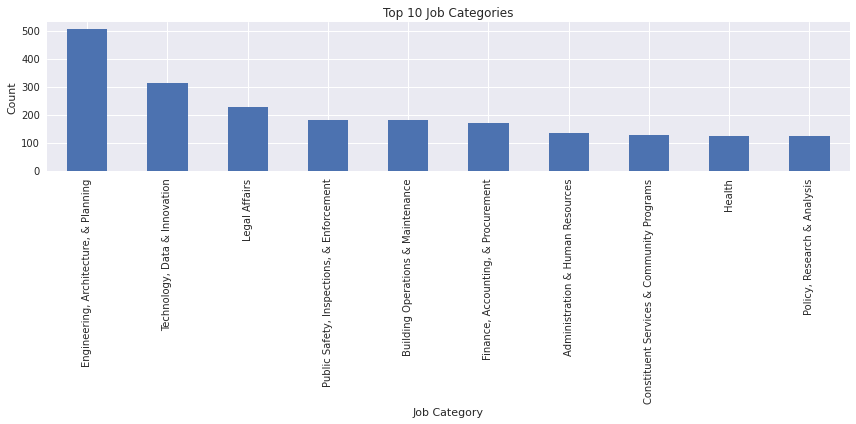

In [271]:
plt.figure(figsize=(12, 6))
pdf["job_category"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Job Categories")
plt.xlabel("Job Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Salary distribution by category (boxplot)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  """


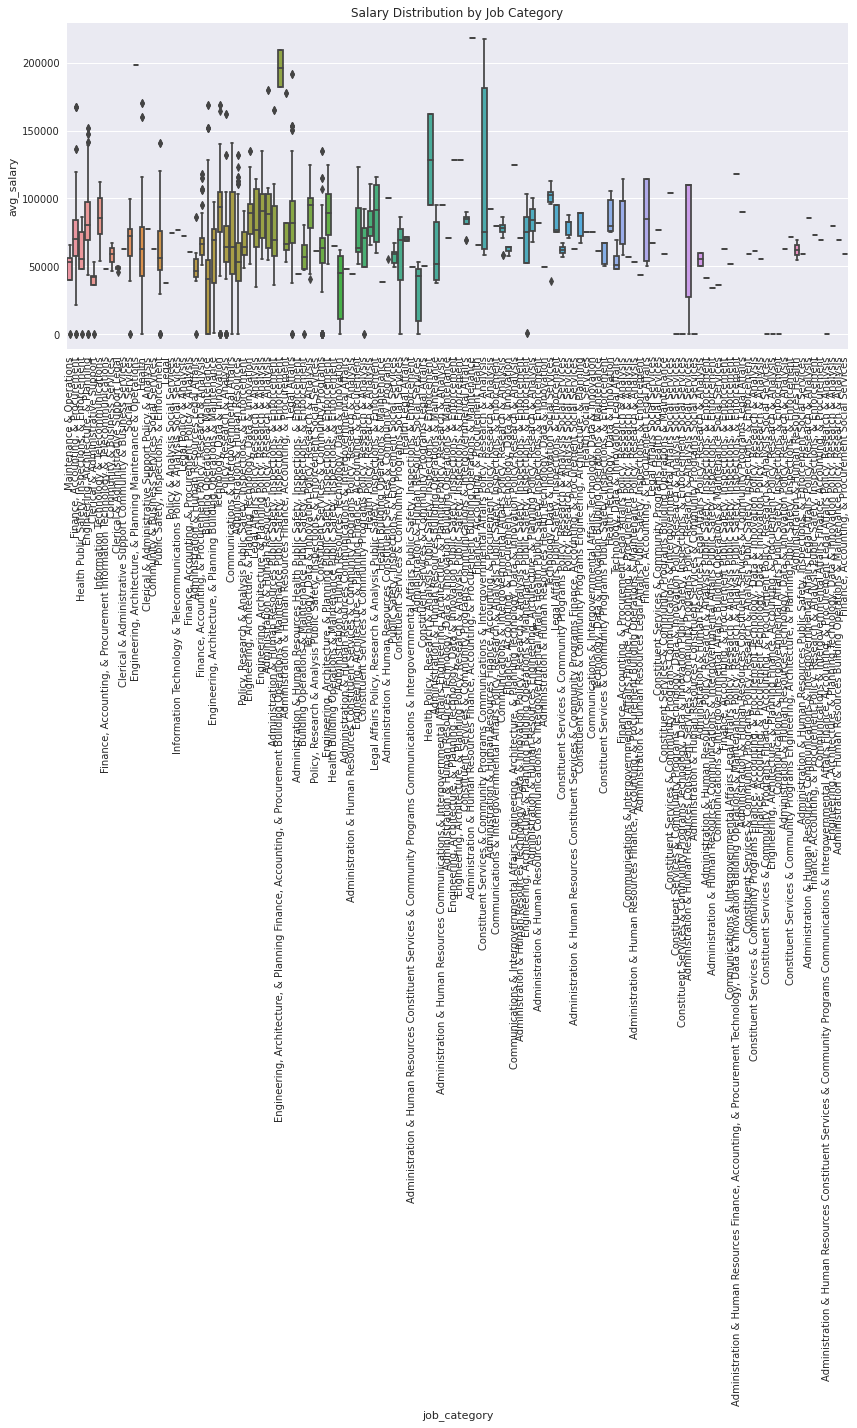

In [272]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=pdf, x="job_category", y="avg_salary")
plt.xticks(rotation=90)
plt.title("Salary Distribution by Job Category")
plt.tight_layout()
plt.show()

### Degree level vs salary (scatter)

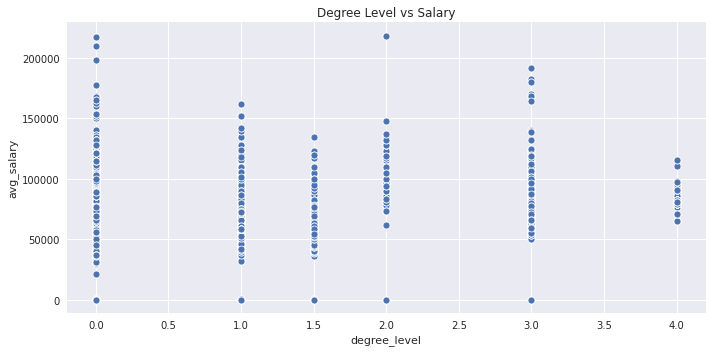

In [273]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=pdf, x="degree_level", y="avg_salary")
plt.title("Degree Level vs Salary")
plt.tight_layout()
plt.show()

# TEST CASES
### This section contains unit tests for the data processing functions.
### Tests validate:
### Salary casting
### Degree level mapping
### Posting year extraction
### All tests passed successfully.

In [274]:
from pyspark.sql import Row

print(" TEST 1: Salary Casting ")
test_df1 = spark.createDataFrame(
    [Row(salary_range_from="10000", salary_range_to="20000")]
)
test_df1 = cast_salary_columns(test_df1)
test_df1.show()


print("TEST 2: Degree Mapping")
test_df2 = spark.createDataFrame(
    [Row(minimum_qual_requirements="Bachelor degree required")]
)
test_df2 = map_degree_level(test_df2)
test_df2.show()


print("TEST 3: Posting Year Extraction")
test_df3 = spark.createDataFrame(
    [Row(posting_date="2015-01-01T00:00:00.000")]
)
test_df3 = extract_posting_year(test_df3)
test_df3.show()

=== TEST 1: Salary Casting ===
+-----------------+---------------+-----------+---------+----------+
|salary_range_from|salary_range_to|salary_from|salary_to|avg_salary|
+-----------------+---------------+-----------+---------+----------+
|            10000|          20000|      10000|    20000|   15000.0|
+-----------------+---------------+-----------+---------+----------+

=== TEST 2: Degree Mapping ===
+-------------------------+------------+
|minimum_qual_requirements|degree_level|
+-------------------------+------------+
|     Bachelor degree r...|         2.0|
+-------------------------+------------+

=== TEST 3: Posting Year Extraction ===
+-------------------+------------+
|       posting_date|posting_year|
+-------------------+------------+
|2015-01-01 00:00:00|        2015|
+-------------------+------------+



### Writing to Target file

In [275]:
print(" Writing Processed Data to Disk ")

processed_df.write.mode("overwrite").parquet("/output/processed_jobs_parquet")

processed_df.write.mode("overwrite") \
    .option("header", True) \
    .csv("/output/processed_jobs_csv")

print("Data successfully written to /output/processed_jobs_parquet and /output/processed_jobs_csv")

=== Writing Processed Data to Disk ===
Data successfully written to /output/processed_jobs_parquet and /output/processed_jobs_csv


In [276]:
import os

print("Parquet files:", os.listdir("/output/processed_jobs_parquet"))
print("CSV files:", os.listdir("/output/processed_jobs_csv"))

Parquet files: ['_SUCCESS', '._SUCCESS.crc']
CSV files: ['_SUCCESS', '._SUCCESS.crc']


In [277]:
processed_df.count()

2946

In [283]:
import shutil

shutil.rmtree("project/output/processed_jobs", ignore_errors=True)
shutil.rmtree("project/output/processed_jobs_parquet", ignore_errors=True)

In [284]:
import os

print(os.path.exists("project/output/processed_jobs"))
print(os.path.exists("project/output/processed_jobs_parquet"))

False
False


In [285]:
os.makedirs("project/output/processed_jobs", exist_ok=True)
os.makedirs("project/output/processed_jobs_parquet", exist_ok=True)

In [292]:
import os
print(os.getcwd())

/notebook


In [293]:
print(os.listdir("."))

['.ipynb_checkpoints', 'assesment_notebook.ipynb', 'output', 'project']


In [294]:
print(os.listdir("/notebook/project/output"))

['processed_jobs', 'processed_jobs_parquet', 'test_write.txt']


In [295]:
print(os.listdir("/notebook/project/output/processed_jobs"))
print(os.listdir("/notebook/project/output/processed_jobs_parquet"))

['._SUCCESS.crc', '_SUCCESS']
['._SUCCESS.crc', '_SUCCESS']


In [296]:
print("Row count before write:", processed_df.count())
processed_df.show(5, truncate=False)

Row count before write: 2946
+------+----------------------------+------------+------------+----------------------------------------------------+------------------------------+-------------+-----+------------------------+-----------------------------+-----------------+---------------+----------------+----------------------------+------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [297]:
spark.sparkContext.master

'spark://master:7077'

In [305]:
spark.sparkContext.parallelize([1,2,3]).saveAsTextFile("/output/test_rdd")

In [306]:
print(os.listdir("/output/test_rdd"))

['_SUCCESS', '._SUCCESS.crc']


In [307]:
pdf = processed_df.toPandas()
pdf.to_csv("processed_jobs.csv", index=False)
pdf.to_parquet("processed_jobs.parquet")

In [308]:
import os
print(os.listdir("."))

['.ipynb_checkpoints', 'assesment_notebook.ipynb', 'output', 'processed_jobs.csv', 'processed_jobs.parquet', 'project']


In [309]:
import shutil

shutil.move("processed_jobs.csv", "project/output/processed_jobs.csv")
shutil.move("processed_jobs.parquet", "project/output/processed_jobs.parquet")

'project/output/processed_jobs.parquet'

In [310]:
import os
print(os.listdir("project/output"))

['processed_jobs', 'processed_jobs.csv', 'processed_jobs.parquet', 'processed_jobs_parquet', 'test_write.txt']


### Sample function

In [48]:
def get_salary_frequency(df: DataFrame) -> list:
    row_list = df.select('Salary Frequency').distinct().collect()
    return [row['Salary Frequency'] for row in row_list]

### Example of test function

In [65]:
mock_data = [('A', 'Annual'), ('B', 'Daily')]
expected_result = ['Annual', 'Daily']

In [66]:
def test_get_salary_frequency(mock_data: list, 
                              expected_result: list,
                              schema: list = ['id', 'Salary Frequency']):  #final
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    assert get_salary_frequency(mock_df) == expected_result